# Emission Measure Analysis with *Hinode*/EIS: Idealized Dipole, Control Model

In [832]:
import os
import logging
import urllib
import io

import pandas
import numpy as np
from scipy.ndimage import map_coordinates
from scipy.interpolate import splev,splrep
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import ChiantiPy.tools.util as ch_util
import hissw
import synthesizAR
from synthesizAR.instruments import InstrumentHinodeEIS
from synthesizAR.atomic import EmissionModel
from synthesizAR.util import EISCube


%matplotlib inline

We'll try to calculate the emission measure distribution using synthesized EIS observations from the control model of our idealized dipolar active region.

## Contribution Functions
First, we need to calculate the contribution functions for each of the resolved transitions we've modeled. These are all denoted in our emission model. Note that the contribution function for a particular transition $\lambda_{ij}$ is given by,

$$
G_{\lambda_{ij}}(n,T) = \frac{1}{4\pi}0.83\mathrm{Ab}(Z)\frac{N_{Z,z}}{N_Z}\varepsilon_{\lambda_{ij}}(n,T)\frac{1}{n}
$$

in units of str$^{-1}$ photons cm$^3$ s$^{-1}$.

In [2]:
emission_model = EmissionModel.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/emission_model1109_full/')

H I psplups file not found
He II psplups file not found
N VII psplups file not found
O VIII psplups file not found
Ne X psplups file not found
Na XI psplups file not found
Mg XII psplups file not found
Al XIII psplups file not found
Si XIV psplups file not found
P XV psplups file not found
S XVI psplups file not found
Cl XVII psplups file not found
Ar XVIII psplups file not found
K XIX psplups file not found
Ca XX psplups file not found
Fe XXVI psplups file not found
Ni XXVIII psplups file not found
He I psplups file not found
C V psplups file not found
N VI psplups file not found
O VII psplups file not found
Ne IX psplups file not found
Na X psplups file not found
Mg XI psplups file not found
Al XII psplups file not found
Si XIII psplups file not found
P XIV psplups file not found
S XV psplups file not found
Cl XVI psplups file not found
Ar XVII psplups file not found
K XVIII psplups file not found
Ca XIX psplups file not found
Fe XXV psplups file not found
Ni XXVII psplups file not f

Choose a temperature and density to calculate the contribution function over. This means interpolating the emissivity and fractional ionization appropriately. We'll use a typical temperature range with a constant pressure of $10^{15}$ K/cm$^3$.

In [534]:
pressure_const = 1e15*u.K*u.cm**(-3)
class FakeLoop(object):
    temperature = np.logspace(5.0,8.0,150)*u.K
    density = pressure_const/temperature
    
fake_loop = FakeLoop()

In [535]:
i_temperature,i_density = emission_model.interpolate_to_mesh_indices(fake_loop)

In [536]:
contribution_functions = {}

In [537]:
for ion in emission_model.ions:
    for rw in ion.resolved_wavelengths:
        i_rw = np.where(ion.wavelength==rw)[0][0]
        emiss = map_coordinates(ion.emissivity[:,:,i_rw].value,
                                np.vstack([i_temperature,i_density]),order=3)*ion.emissivity.unit
        ioneq = splev(fake_loop.temperature.value,
                      splrep(emission_model.temperature_mesh[:,0].value,
                             ion.fractional_ionization[:,0].value,k=1),ext=1)
        key = '{}_{}'.format(ion.chianti_ion.meta['name'],rw.value)
        contribution_functions[key] = (rw,(1./(np.pi*4.*u.steradian)*0.83
                                           *ioneq*ion.chianti_ion.abundance*emiss/fake_loop.density
                                           *(const.h.cgs*const.c.cgs)/rw.to(u.cm)/u.photon
                                          )
                                      )

In [538]:
accept_these_ions = ['si_7_275.3612',
                     'fe_10_184.537',
                     'fe_12_195.119',
                     'ca_17_192.8532',
                     'ca_14_193.8661',
                     'fe_9_188.493',
                     's_13_256.6852',
                     'ca_15_200.9719',
                     'fe_15_284.163'
                    ]

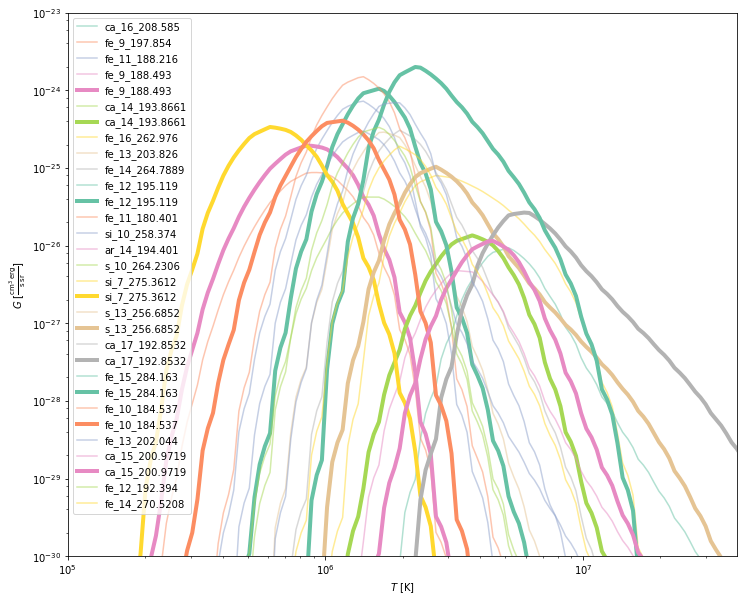

In [539]:
gofnt_colors = {k : sns.color_palette('Set2',len(contribution_functions))[i] for i,k in enumerate(contribution_functions)}
plt.figure(figsize=(12,10))
for k in contribution_functions:
    plt.plot(fake_loop.temperature,contribution_functions[k][1],color=gofnt_colors[k],alpha=0.5,label=k)
    if k in accept_these_ions:
        plt.plot(fake_loop.temperature,contribution_functions[k][1],label=k,
                     color=gofnt_colors[k],lw=4)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30,1e-23])
plt.xlim([10**(5.0),10**(7.6)])
plt.xlabel(r'$T$ [{:latex}]'.format(fake_loop.temperature.unit))
plt.ylabel(r'$G$ [{:latex}]'.format(contribution_functions[k][1].unit))
plt.legend(loc='best')

## Instrument Response Function
We need to convert the observed intensities and contribution functions to the same units. We'll use the EIS response functions.

In [540]:
eis = InstrumentHinodeEIS([0,1e4]*u.s)

Do a comparison with those found in IDL/SSW.

In [843]:
eis_response_script = """
; set environment variable
setenv,'EIS_RESPONSE='+getenv('SSW')+'/hinode/eis/response/'
n_wvl = 1000
; B channel
wvl0 = 160
wvl1 = 215
wavelength_b = wvl0 + findgen(n_wvl)*(wvl1 - wvl0)/(n_wvl - 1)
; A channel
wvl0 = 235
wvl1 = 295
wavelength_a = wvl0 + findgen(n_wvl)*(wvl1 - wvl0)/(n_wvl - 1)
; calculate effective areas
eff_area_a = eis_eff_area(wavelength_a)
eff_area_b = eis_eff_area(wavelength_b)
"""

In [844]:
save_vars = ['wavelength_a','eff_area_a','wavelength_b','eff_area_b']

In [845]:
eis_response_runner = hissw.ScriptMaker(ssw_pkg_list=['hinode/eis'],ssw_path_list=['eis'])

In [846]:
eis_eff_area = eis_response_runner.run([(eis_response_script,{})],save_vars=save_vars)

SSW  setup will include: <gen hinode/eis>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Invalid MIT-MAGIC-COOKIE-1 key% DEVICE: Unable to connect to X Windows display: :0.0
Executing SSW IDL_STARTUP for: SITE
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
Including Paths:
 -------------------------------------------------------------
| $SSW/hin

In [883]:
elec_per_photon_a = (const.h*const.c).to(u.eV*u.angstrom)/(eis_eff_area['wavelength_a']*u.angstrom)/u.photon/(3.65*u.eV/u.electron)

In [884]:
elec_per_photon_b = (const.h*const.c).to(u.eV*u.angstrom)/(eis_eff_area['wavelength_b']*u.angstrom)/u.photon/(3.65*u.eV/u.electron)

In [885]:
plate_scale = (1*u.arcsec**2).to(u.steradian)/u.pixel

Plot

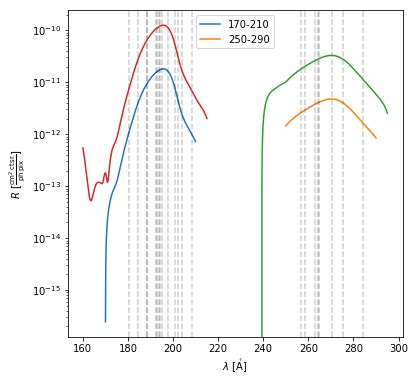

In [888]:
plt.figure(figsize=(6,6))
# synthesizAR
for chan in eis.channels:
    plt.plot(chan['response']['x'],chan['response']['y'],label=chan['name'])
# modeled resolved lines
for rw in emission_model.resolved_wavelengths:
    plt.axvline(x=rw.value,color='k',linestyle='--',alpha=0.2)
# SSW
plt.plot(eis_eff_area['wavelength_a'],
         eis_eff_area['eff_area_a']*plate_scale*elec_per_photon_a)
plt.plot(eis_eff_area['wavelength_b'],
         eis_eff_area['eff_area_b']*plate_scale*elec_per_photon_b)
plt.ylabel(r'$R$ [{:latex}]'.format(chan['response']['y'].unit))
plt.xlabel(r'$\lambda$ [{:latex}]'.format(chan['response']['x'].unit))
plt.yscale('log')
plt.legend(loc='best')

## Observed Intensities
Load the data cubes for both EIS channels at a particular timestep. We'll need to make a spatial selection, somewhere near the core. This will reduce our observations to 1D spectra. Using these spectra, we will then make selections in wavelength space and integrate over the appropriate interval in $\lambda$. 

In [938]:
width,height = 2*u.arcsec,2*u.arcsec
left_x,bottom_y = 0*u.arcsec,0*u.arcsec

In [957]:
timestep = 4500*u.s

In [958]:
channel_1_cube = EISCube('/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/Hinode_EIS/170-210/map_t{:06d}.h5'.format(np.where(eis.observing_time==timestep)[0][0]))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


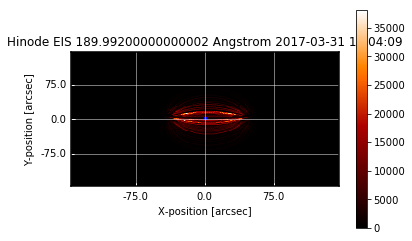

In [959]:
channel_1_cube.integrated_intensity.peek()
channel_1_cube.integrated_intensity.draw_rectangle(u.Quantity([left_x.value,bottom_y.value],left_x.unit),
                                                   width,height,
                                                   color='b',lw=2)

In [960]:
channel_2_cube = EISCube('/data/datadrive1/ar_forward_modeling/systematic_ar_study/idealized_dipole/Hinode_EIS/250-290/map_t{:06d}.h5'.format(np.where(eis.observing_time==timestep)[0][0]))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


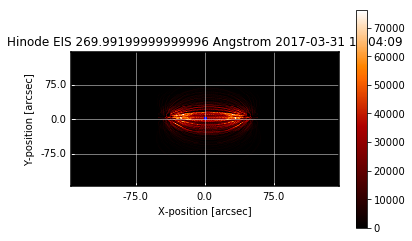

In [961]:
channel_2_cube.integrated_intensity.peek()
channel_2_cube.integrated_intensity.draw_rectangle(u.Quantity([left_x.value,bottom_y.value],left_x.unit),
                                                   width,height,
                                                   color='b',lw=2)

Convert the intensities to physical units using the response functions.

In [962]:
interpolated_response = splev(channel_1_cube.wavelength.value,
                              splrep(eis.channels[0]['response']['x'].value,
                                     eis.channels[0]['response']['y'].value),ext=1)*eis.channels[0]['response']['y'].unit
channel_1_physical = channel_1_cube*(1./interpolated_response)*const.h.cgs*const.c.cgs*(1./channel_1_cube.wavelength.to(u.cm))*(1./u.photon)

In [963]:
interpolated_response = splev(channel_2_cube.wavelength.value,
                              splrep(eis.channels[1]['response']['x'].value,
                                     eis.channels[1]['response']['y'].value),ext=1)*eis.channels[1]['response']['y'].unit

channel_2_physical = channel_2_cube*(1./interpolated_response)*const.h.cgs*const.c.cgs*(1./channel_2_cube.wavelength.to(u.cm))*(1./u.photon)

In [964]:
intensities = {}

In [965]:
for key in contribution_functions:
    rw = contribution_functions[key][0]
    # find the channel
    for cube in [channel_1_physical,channel_2_physical]:
        if cube.wavelength[0] <= rw <= cube.wavelength[-1]:
            # select in wavelength space around transition center
            i = np.argwhere(np.isclose(cube.wavelength.value,rw.value,rtol=0.0,atol=1.1e-2))[0][0]
            integrated_intensity = cube[i-10:i+10].integrated_intensity
            # spatial selection
            left_pixel,bottom_pixel = integrated_intensity.data_to_pixel(left_x,bottom_y)
            right_pixel,top_pixel = integrated_intensity.data_to_pixel(left_x + width,bottom_y + height)
            # get average intensity
            intensities[key] = (integrated_intensity.data[int(np.floor(bottom_pixel.value)):int(np.ceil(top_pixel.value)),
                                                         int(np.floor(left_pixel.value)):int(np.ceil(right_pixel.value))].mean()
                                * u.Unit(integrated_intensity.meta['bunit']))

## Emission Measure Analysis

### EM Loci Method
First, we'll use a simple EM Loci method to estimate the shape of the emission measure distribution. Recalling that the intensity, in units of erg cm$^{-2}$ s$^{-1}$, for a particular line $\lambda_{ij}$ is given by,

$$
I_{ij} = \frac{1}{4\pi}\int\mathrm{d}T\mathrm{DEM}(T)G_{ij}(n,T)
$$

Taking the plasma to be isothermal over a discrete number of temperature bins defined by the sensitivity of the contribution functions for a set of lines, we can take $G$ outside of the integral and "invert" the equation to give the emission measure distribution in the temperature bin for the line $\lambda_{ij}, 

$$
\mathrm{EM} = \int_{LOS}\mathrm{d}h\,n_e^2 = \frac{I_{ij}}{G_{ij}(T)}.
$$

Doing this for many lines gives an estimate of the emission measure in discrete temperature bins.

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/astropy/units/quantity.py:951: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)


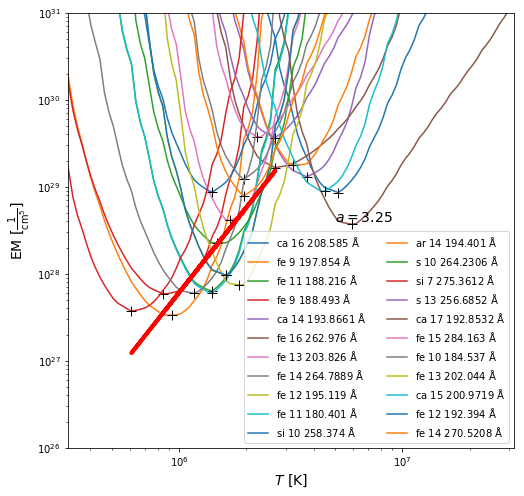

In [966]:
plt.figure(figsize=(8,8))
t_fit,em_fit = [],[]
for key in contribution_functions:
    #if key in accept_these_ions:
        em_loci = intensities[key]/contribution_functions[key][1]
        i_min = np.argmin(em_loci)
        plt.plot(fake_loop.temperature,em_loci,
                 label='{} {} {} $\mathrm{{\AA}}$'.format(key.split('_')[0],key.split('_')[1],key.split('_')[2]))
        plt.plot(fake_loop.temperature[i_min],em_loci[i_min],'k+',markersize=10)
        t_fit.append(fake_loop.temperature[i_min].value)
        em_fit.append(em_loci[i_min].value)
# fitting
def linear_func(x,a,b):
    return a*x + b
upper_t_lim = 3.e6
lower_t_lim = 0.5e6
i_fit = np.where(np.logical_and(np.array(t_fit)<=upper_t_lim,np.array(t_fit)>=lower_t_lim))[0]
logt_fit = np.log10(t_fit)[i_fit]
logem_fit = np.log10(em_fit)[i_fit]
popt,pcov = curve_fit(linear_func,logt_fit,logem_fit)
y_fit = 10.**(linear_func(logt_fit,*popt))
plt.plot(10.**(logt_fit),y_fit,'-r',lw=4)
# labels
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e26,1e31])
plt.xlim([10**(5.5),10**(7.5)])
plt.ylabel(r'$\mathrm{{EM}}$ [{:latex}]'.format(em_loci.unit.decompose().cgs),fontsize=14)
plt.xlabel(r'$T$ [{:latex}]'.format(fake_loop.temperature.unit),fontsize=14)
plt.text(5e6,4e28,r'$a = {:.2f}$'.format(popt[0]),fontsize=14)
plt.legend(loc=4,ncol=2)

### Regularized Method of Hannah and Kontar
Run the `demreg` code developed by Hannah and Kontar, a regularized inversion method.

In [967]:
ssw_script = """
; load intensity and contribution function values
line_names = {{ line_names }}
line_intensity = {{ line_intensity }}
contribution_functions = {{ contribution_functions }}

; load temperature over which contribution functions are calculated
log_temperature = {{ log_temperature }}

; bad estimate of intensity errors
line_intensity_errors = line_intensity*{{ error_ratio }}

; inversion method parameters
order={{ order }}
reg_tweak={{ reg_tweak }}
guess={{ guess }}
gloci={{ gloci }}
pos={{ pos }}

; run the inversion method
reg=data2dem_reg(log_temperature, contribution_functions, line_intensity, line_intensity_errors,$
 	mint={{min_log_temperature}}, maxt={{max_log_temperature}}, nt={{num_temperature}}, $
	order=order,reg_tweak=reg_tweak, guess=guess, $
	channels=line_names,gloci=gloci,pos=pos)

;dn2dem_pos_nb,line_intensity,line_intensity_errors,contribution_functions,log_temperature,temps,$
;    dem,edem,elogt,chisq,dn_reg,/timed,/gloci
"""

Format data to be passed to the IDL script.

In [968]:
gofnt_matrix = []
intensity_array = []
line_names = []
log_temperature = np.log10(fake_loop.temperature.value).tolist() 

In [969]:
for key in contribution_functions:
    #if key in accept_these_ions:
        line_names.append('_'.join(key.split('_')[:-1]))
        intensity_array.append(intensities[key].value)
        gofnt_matrix.append(contribution_functions[key][1].value.tolist())

In [970]:
demreg_runner = hissw.ScriptMaker(extra_paths=['/home/wtb2/Documents/codes/demreg/idl_org/'])

In [971]:
input_vars = {'line_names':line_names,'line_intensity':intensity_array,
              'contribution_functions':gofnt_matrix,'log_temperature':log_temperature,
              'min_log_temperature':5.7,'max_log_temperature':7.1,'num_temperature':30,
              'error_ratio':0.45,
              'order':0,'gloci':1,'guess':0,'pos':1,'reg_tweak':1
             }
save_vars = ['reg']#['logtemps','mlogt','dem','edem','dn','edn']

In [972]:
demreg_results = demreg_runner.run([(ssw_script,input_vars)],save_vars=save_vars,cleanup=True,verbose=True)

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Invalid MIT-MAGIC-COOKIE-1 key% DEVICE: Unable to connect to X Windows display: :0.0
Executing SSW IDL_STARTUP for: SITE
% Program caused arithmetic error: Floating underflow
% Compiled module: DATA2DEM_REG.
% Compiled module: INTERPOL.
% Compiled module: DEM_INV_MAKE_CONSTRAINT.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_POS.
% Compiled module: DEM_INV_REG_SOLUTION.
Regularization parameter (discrepancy):      0.014077484
% Compiled module: 

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide


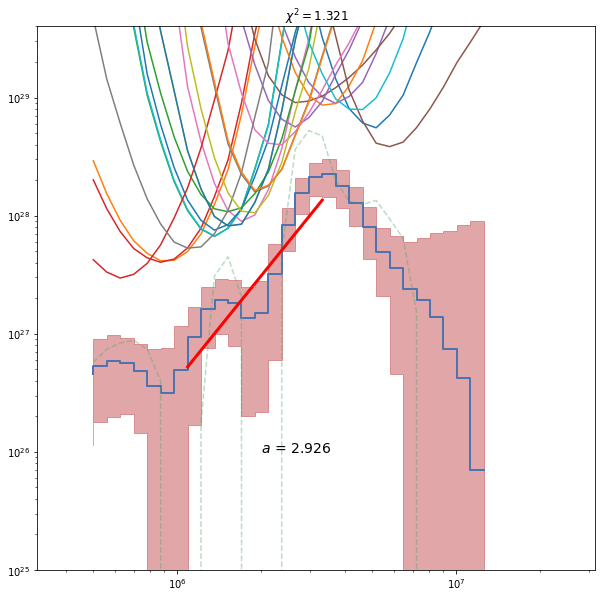

In [975]:
plt.figure(figsize=(10,10))
# DEM and EM loci curves
plt.step(10**demreg_results['reg']['logt'][0],
         demreg_results['reg']['dem_pos'][0]*demreg_results['reg']['demtoem'][0],
         color=sns.color_palette('deep')[0],ls='-',lw=2)
plt.fill_between(10**demreg_results['reg']['logt'][0],
                y1=(demreg_results['reg']['dem_pos'][0] - demreg_results['reg']['edem_pos'][0])*demreg_results['reg']['demtoem'][0],
                y2=(demreg_results['reg']['dem_pos'][0] + demreg_results['reg']['edem_pos'][0])*demreg_results['reg']['demtoem'][0],
                 color=sns.color_palette('deep')[2],alpha=0.5,step='pre')
plt.plot(10**demreg_results['reg']['logt'][0],
         demreg_results['reg']['dem'][0]*demreg_results['reg']['demtoem'][0],
         color=sns.color_palette('deep')[1],ls='--',alpha=0.4,)
for i in range(demreg_results['reg']['tresp'][0].shape[0]):
    plt.plot(10.**demreg_results['reg']['logt'][0],demreg_results['reg']['data_reg_pos'][0][i]/demreg_results['reg']['tresp'][0][i,:])
# fitting
i_fit = np.where(np.logical_and(demreg_results['reg']['logt'][0]>=6.0,
                                demreg_results['reg']['logt'][0]<=6.55))
t_fit = np.float64(demreg_results['reg']['logt'][0][i_fit])
em_fit = (demreg_results['reg']['dem_pos'][0]*demreg_results['reg']['demtoem'][0])[i_fit]
popt,pcov = curve_fit(linear_func,t_fit,np.log10(em_fit))
y_fit = 10.**(linear_func(t_fit,*popt))
plt.plot(10.**t_fit,y_fit,'-r',lw=3)
# labels
plt.title(r'$\chi^2={:.3f}$'.format(demreg_results['reg']['chisq_pos'][0]))
plt.text(2e6,1e26,r'$a$ = {:.3f}'.format(popt[0]),fontsize=14)
plt.ylim([1e25,4e29])
plt.xlim([10**5.5,10.**7.5])
plt.yscale('log')
plt.xscale('log')

## Recreating DEM of Warren et al
Pull down the data from Warren et al. (2012) and used the observed intensities, measured in units of erg cm$^{-2}$ s$^{-1}$ str$^{-1}$, along with our computed contribution functions, to calculate the emission measure distribution.

In [480]:
tmp = (urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t2_mrt.txt')
                     .readlines())
col_names = [str(t.strip()).split('  ')[-1] for t in tmp[8:15]]
col_names = [c[:-1] for c in col_names[0:2]] + ['Element','Ion','Wavelength'] + [c[:-1] for c in col_names[3:]]
table_io = io.StringIO(','.join(col_names) + '\n' 
                       + '\n'.join([','.join(filter(None,t.strip().decode('utf8').split(' '))) for t in tmp[19:]]))
df = pandas.read_csv(table_io)
df = df[df['Active region']==9]
df = df[df['Instrument (1)']=='EIS']

In [481]:
gofnt_matrix_warren = []
intensity_array_warren = []
intensities_warren = {}
line_names_warren = []

In [482]:
for i,row in df.iterrows():
    # fix wavelength
    wave_fix = min(emission_model.resolved_wavelengths.value,key=lambda x:abs(x - float(row['Wavelength'])))
    ion_name = ch_util.spectroscopic2name(row['Element'],row['Ion'])
    key = '{}_{}'.format(ion_name,wave_fix)
    if key in accept_these_ions:
        intensities_warren[key] = row['Observed intensity']*u.erg/(u.cm**2)/u.s/u.steradian
        intensity_array_warren.append(row['Observed intensity'])
        gofnt_matrix_warren.append(contribution_functions[key][1].value.tolist())
        line_names_warren.append(ion_name)

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/astropy/units/quantity.py:951: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)


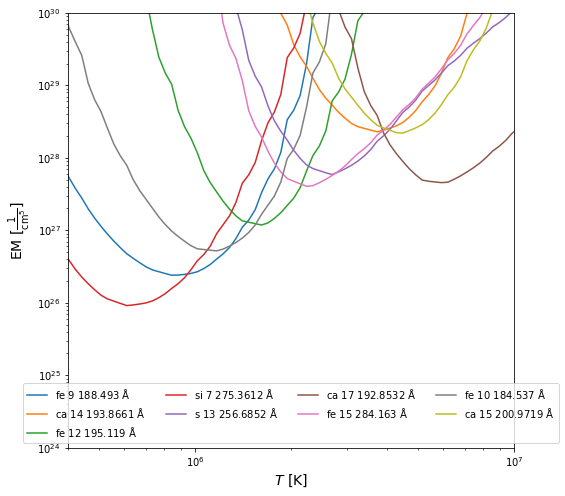

In [502]:
plt.figure(figsize=(8,8))
t_fit,em_fit = [],[]
for key in contribution_functions:
    if key in accept_these_ions:
        em_loci = intensities_warren[key]/contribution_functions[key][1]
        i_min = np.argmin(em_loci)
        plt.plot(fake_loop.temperature,em_loci,
                 label='{} {} {} $\mathrm{{\AA}}$'.format(key.split('_')[0],key.split('_')[1],key.split('_')[2]))
        #plt.plot(fake_loop.temperature[i_min],em_loci[i_min],'k+',markersize=10)
        t_fit.append(fake_loop.temperature[i_min].value)
        em_fit.append(em_loci[i_min].value)
# fitting
def linear_func(x,a,b):
    return a*x + b
upper_t_lim = 4.e6
lower_t_lim = 0.9e6
i_fit = np.where(np.logical_and(np.array(t_fit)<=upper_t_lim,np.array(t_fit)>=lower_t_lim))[0]
logt_fit = np.log10(t_fit)[i_fit]
logem_fit = np.log10(em_fit)[i_fit]
popt,pcov = curve_fit(linear_func,logt_fit,logem_fit)
y_fit = 10.**(linear_func(logt_fit,*popt))
#plt.plot(10.**(logt_fit),y_fit,'-r',lw=4)
# labels
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e24,1e30])
plt.xlim([10**(5.6),10**(7.0)])
plt.ylabel(r'$\mathrm{{EM}}$ [{:latex}]'.format(em_loci.unit.decompose().cgs),fontsize=14)
plt.xlabel(r'$T$ [{:latex}]'.format(fake_loop.temperature.unit),fontsize=14)
#plt.text(5e6,1e27,r'$a = {:.2f}$'.format(popt[0]),fontsize=14)
plt.legend(loc='lower center',ncol=4)

In [527]:
ssw_script_warren = """
; load intensity and contribution function values
line_names = {{ line_names }}
line_intensity = {{ line_intensity }}
contribution_functions = {{ contribution_functions }}

; load temperature over which contribution functions are calculated
log_temperature = {{ log_temperature }}

; bad estimate of intensity errors
line_intensity_errors = line_intensity*0.2

; inversion method parameters
order=0
reg_tweak=1
guess=0
gloci=1
pos=1

; run the inversion method
reg=data2dem_reg(log_temperature, contribution_functions, line_intensity, line_intensity_errors,$
 	mint={{min_log_temperature}}, maxt={{max_log_temperature}}, nt={{num_temperature}}, $
	order=order,reg_tweak=reg_tweak, guess=guess, $
	channels=line_names,gloci=gloci,pos=pos)

;dn2dem_pos_nb,line_intensity,line_intensity_errors,contribution_functions,log_temperature,temps,$
;    dem,edem,elogt,chisq,dn_reg,/timed,/gloci
"""

In [528]:
input_vars_warren = {'line_names':line_names_warren,'line_intensity':intensity_array_warren,
              'contribution_functions':gofnt_matrix_warren,'log_temperature':log_temperature,
              'min_log_temperature':5.5,'max_log_temperature':7,'num_temperature':50
             }
save_vars_warren = ['reg']

In [529]:
warren_run = demreg_runner.run([(ssw_script_warren,input_vars_warren)],
                                   save_vars=save_vars_warren,cleanup=True,verbose=True)

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Invalid MIT-MAGIC-COOKIE-1 key% DEVICE: Unable to connect to X Windows display: :0.0
Executing SSW IDL_STARTUP for: SITE
% Program caused arithmetic error: Floating underflow
% Compiled module: DATA2DEM_REG.
% Compiled module: INTERPOL.
% Compiled module: DEM_INV_MAKE_CONSTRAINT.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_POS.
% Compiled module: DEM_INV_REG_SOLUTION.
Regularization parameter (discrepancy):        3.7088845
% Compiled module: 

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/astropy/units/quantity.py:951: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide


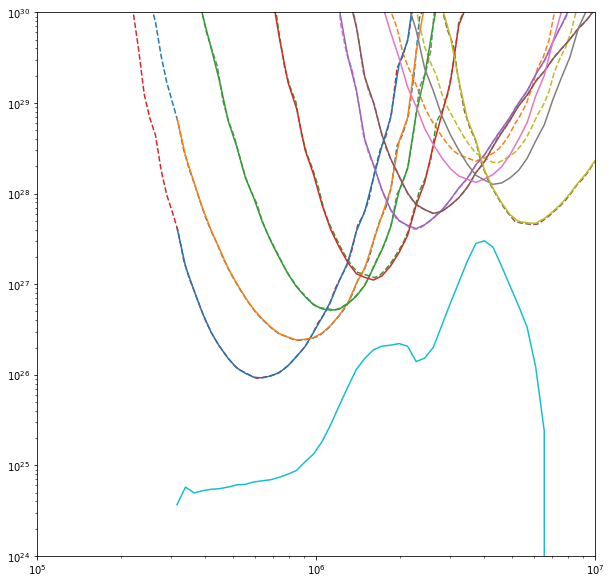

In [533]:
plt.figure(figsize=(10,10))
for key in contribution_functions:
    if key in accept_these_ions:
        em_loci = intensities_warren[key]/contribution_functions[key][1]
        plt.plot(fake_loop.temperature,em_loci,
                 linestyle='--',
                 label='{} {} {} $\mathrm{{\AA}}$'.format(key.split('_')[0],key.split('_')[1],key.split('_')[2]))
plt.plot(10**warren_run['reg']['logt'][0],warren_run['reg']['dem'][0]*warren_run['reg']['demtoem'][0])
for i in range(warren_run['reg']['tresp'][0].shape[0]):
    plt.plot(10.**warren_run['reg']['logt'][0],warren_run['reg']['data_reg'][0][i]/warren_run['reg']['tresp'][0][i,:])
plt.ylim([1e24,1e30])
plt.xlim([1e5,1e7])
plt.yscale('log')
plt.xscale('log')

## Sample Script
Run the sample script that is included in the demreg repo

In [834]:
sample_script="""
restore,file='/home/wtb2/Documents/codes/demreg/idl_org/con_func_9.dat'

; ; line intensities in erg/cm^2/s/sr
;; these intesities for the lines in cf are from the CHIANTI /qs DEM model 
line_in=[489.7,  267.5, 4.9,  77.4, 67.2,  26.5,  47.1,  235.9, 6.9]

; ; error in erg/cm^2/s/sr
; ; just assume % of line intensities
eline_in=line_in*0.10

; ; get all the contribution functions from the save structure
; ;  units of are erg cm^3/s/sr
CFmatrix=cf.con_func
; ; what is the logT binning of the contribution functions
logt=cf[0].logt

; ;order of regularization, default is 0th
order=2
; ;control the regularization parameter/chisq of result in DEM space: reg_tweak=1
reg_tweak=1
; ;Use guess solution in final regularization? default is no, guess=0.
guess=1
;; Use the min of the EM loci curves as the initial guess solution
;; used to weight/create the constraint matrix and possibly in the regularization itself (if guess=1)
gloci=0

; run the regularization
reg=data2dem_reg(logT, CFmatrix, line_in, eline_in,$
 	mint=5.0, maxt=6.7, nt=50, $
	order=order,reg_tweak=reg_tweak, guess=guess, $
	channels=cf.line,gloci=gloci)
"""

In [835]:
sample_run = demreg_runner.run([(sample_script,{})],save_vars=['reg'])

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Invalid MIT-MAGIC-COOKIE-1 key% DEVICE: Unable to connect to X Windows display: :0.0
Executing SSW IDL_STARTUP for: SITE
% Compiled module: DATA2DEM_REG.
% Compiled module: INTERPOL.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER.
Regularization parameter (discrepancy):      0.049765954
% Compiled module: DEM_INV_REG_SOLUTION.
% Compiled module: DEM_INV_MAKE_CONSTRAINT.
Regularization parameter (discrepancy):        118.14808
% Compiled module: D

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


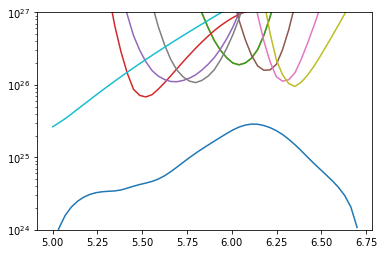

In [836]:
plt.plot(sample_run['reg']['logt'][0],sample_run['reg']['demtoem'][0]*sample_run['reg']['dem'][0])
for i in range(9):
    plt.plot(sample_run['reg']['logt'][0],sample_run['reg']['data_reg'][0][i]/sample_run['reg']['tresp'][0][i,:])
plt.ylim([1e24,1e27])
plt.yscale('log')

(1e-29, 1e-23)

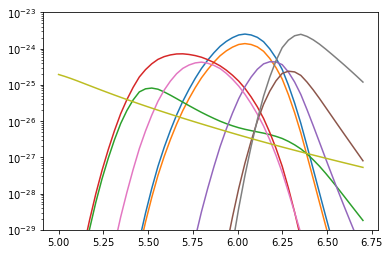

In [837]:
for i in range(9):
    plt.plot(sample_run['reg']['logt'][0],sample_run['reg']['tresp'][0][i,:])
plt.yscale('log')
plt.ylim([1e-29,1e-23])